In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
import matplotlib.patches as mpatches

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('muted')
sns.set_context(
    "notebook",
    font_scale=1,
    rc={"lines.linewidth": 2.5}
)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt 

In [6]:
import torch
import numpy as np
from statistics import mean 
from scipy.stats import pearsonr

In [7]:
from tools.metrics import *
from tools.utils import *
from models.evidential import *
from sklearn.linear_model import LinearRegression


In [9]:
def get_k(aps, k, top=True):
    idxs = list(enumerate(aps))
    s = sorted(idxs, key=lambda x: x[1], reverse=top)
    res = [index for index, value in s[:k]]

    return s[:k]

In [80]:
pred = torch.load('../test/prediction.pt')
gt = torch.load('../test/ground_truth.pt')
ep = torch.load('../test/epistemic.pt')
ood = torch.load('../test/oods.pt')
raw = torch.load('../test/raw.pt')

In [63]:
m = Evidential([0], backbone="lss")
# m.load(torch.load("../outputs/overfitted_demo/79.pt"))

Loaded pretrained weights for efficientnet-b0
Using weights: None
BETA LAMBDA: 0.001


In [64]:
k=20

In [112]:
aps = []
lo = []
ious = []

for i in range(ep.shape[0]):
    a = ood[i]
    b = ep[i, 0]
    
    if a.sum() == 0: continue
    
    fpr, tpr, rec, pr, auroc, ap, no_skill = roc_pr(b, a)
    aps.append(ap)
    lo.append(m.loss_ood(raw[i].to(4)[None], gt[i].to(4)[None], ood[i].long().to(4)[None])[1].item())
    ious.append(unc_iou(b, a).item())

In [98]:
topk = get_k(aps, k)
botk = get_k(aps, k, top=False)

In [99]:
def lobf(x, y, xlim, ax):
    b, a = np.polyfit(x, y, deg=1)
    xseq = np.linspace(xlim[0], xlim[1], num=5)
    ax.plot(xseq, a + b * xseq, "--", c='purple', lw=1.5, alpha=.75);

In [100]:
i = 32

In [101]:
uce = uce_loss(raw[i][None], gt[i][None])

scf = 1 + (ep[i, 0] * 8)
uce *= scf
uce *= (1-ood[i].long())

tensor(6541.1851) tensor(25405.6815, dtype=torch.float64)


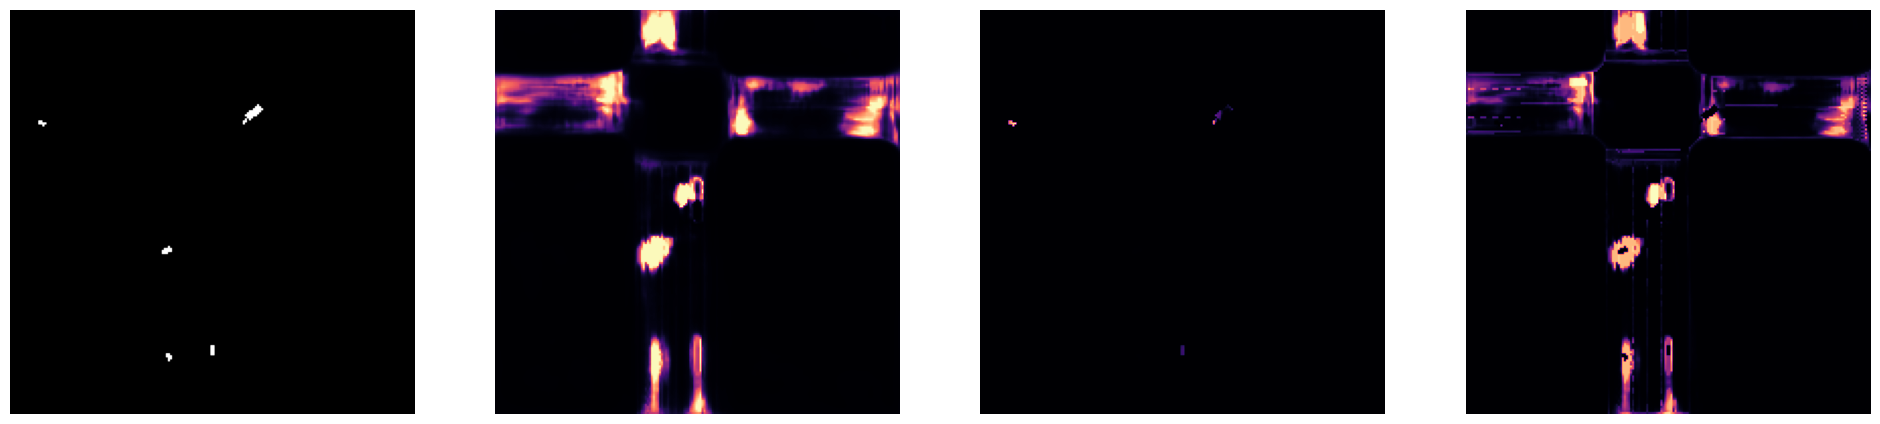

In [102]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

axs[0].imshow(1-ood[i].numpy())
axs[1].imshow(ep[i, 0], cmap='magma')
axs[2].imshow(mr[0, 0].numpy(), cmap='magma')
axs[3].imshow(uce[0, 0].numpy(), cmap='magma')

print(mr.sum(), uce.sum())

for ax in axs.flatten():
    ax.axis("off")

In [1]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(aps, lo, label=f"r={pearsonr(aps, lo)[0]:.5f}", s=20, alpha=.5)
axs[0].set_xlabel("Average Precision")
axs[0].set_ylabel("OOD Reg. Value")
axs[0].set_ylim(-0.05, 1.5)
axs[0].set_xlim(-0.005, .3)
lobf(aps, lo, (-.005, .4), axs[0])
axs[0].legend()

axs[1].scatter(aps, ious, c='g', label=f"r={pearsonr(aps, ious)[0]:.5f}", s=20, alpha=.5)
axs[1].set_xlabel("Average Precision")
axs[1].set_ylabel("Unc. IOU")
axs[1].set_ylim(-0.005, .1)
axs[1].set_xlim(-0.005, .3)
lobf(aps, ious, (-.005, .4), axs[1])
axs[1].legend()

axs[2].scatter(ious, lo, c='r', label=f"r={pearsonr(ious, lo)[0]:.5f}", s=20, alpha=.5)
axs[2].set_xlabel("Unc. IOU")
axs[2].set_ylabel("OOD Reg. Value")
axs[2].set_ylim(-0.05, 1.5)
axs[2].set_xlim(-0.005, .1)
lobf(ious, lo, (-.005, .12), axs[2])
axs[2].legend()

fig.suptitle("Correlations between metrics\nLSS_UFocal_OODReg=1_Vac=32")
plt.tight_layout()

NameError: name 'plt' is not defined

In [ ]:
fig, axs = plt.subplots(4, k, figsize=(4*k, 20))

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for i in range(k):
    idx, ap = topk[i]
    
    axs[0, i].set_title(f"AP={ap:.5f}", fontsize=24)
    axs[0, i].imshow(ep[idx, 0], cmap='inferno')
    
    axs[1, i].set_title(f"OOD ratio={ood[idx].numpy().mean():.5f}", fontsize=24)
    axs[1, i].imshow(ood[idx], cmap='viridis')
    
    iou = get_iou(pred[idx].unsqueeze(0), gt[idx].unsqueeze(0), exclude=ood[idx].unsqueeze(0))
    
    axs[2, i].set_title(f"Avg. IOU={mean(iou):.5f}", fontsize=24)
    axs[2, i].imshow(map_rgb(pred[idx], ego=True) / 255)
    axs[3, i].imshow(map_rgb(gt[idx], ego=True) / 255)
    
axs[0, 0].set_ylabel("Epistemic", fontsize=24)
axs[1, 0].set_ylabel("OOD", fontsize=24)
axs[2, 0].set_ylabel("Prediction", fontsize=24)
axs[3, 0].set_ylabel("Label", fontsize=24)

fig.suptitle(f"LSS-UFocal-OODReg\n Top {k} samples with highest AP\nID classes are [vehicle, road, lane, background]\nRows are [epistemic, ood, prediction, label]\n", fontsize=24)    

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(4, k, figsize=(4*k, 20))

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for i in range(k):
    idx, ap = botk[i]
    
    axs[0, i].set_title(f"AP={ap:.5f}", fontsize=24)
    axs[0, i].imshow(ep[idx, 0], cmap='inferno')
    
    axs[1, i].set_title(f"OOD ratio={ood[idx].numpy().mean():.5f}", fontsize=24)
    axs[1, i].imshow(ood[idx], cmap='viridis')
    
    iou = get_iou(pred[idx].unsqueeze(0), gt[idx].unsqueeze(0), exclude=ood[idx].unsqueeze(0))
    
    axs[2, i].set_title(f"Avg. IOU={mean(iou):.5f}", fontsize=24)
    axs[2, i].imshow(map_rgb(pred[idx], ego=True) / 255)
    axs[3, i].imshow(map_rgb(gt[idx], ego=True) / 255)
    axs[0, i].set_title(f"AP={ap:.5f}", fontsize=24)
    
axs[0, 0].set_ylabel("Epistemic", fontsize=24)
axs[1, 0].set_ylabel("OOD", fontsize=24)
axs[2, 0].set_ylabel("Prediction", fontsize=24)
axs[3, 0].set_ylabel("Label", fontsize=24)

fig.suptitle("LSS-UFocal-OODReg\n Bottom 10 samples with lowest AP\nID classes are [vehicle, road, lane, background]\nRows are [epistemic, ood, prediction, label]\n", fontsize=24)    

fig.tight_layout()

In [ ]:
import matplotlib as mpl
from datasets.carla import CarlaDataset

In [ ]:
cam_names = [
    "FRONT_LEFT_CAMERA",
    "FRONT_CAMERA",
    "FRONT_RIGHT_CAMERA",
    "BACK_LEFT_CAMERA",
    "BACK_CAMERA",
    "BACK_RIGHT_CAMERA",
]

In [ ]:
ood_data = CarlaDataset("../../data/carla/train_aug", False)

In [ ]:
rat = 224/480
val = 10.1
fig = plt.figure(figsize=(val + val/3*2*rat*3, val/3*2*rat))
gs = mpl.gridspec.GridSpec(2, 6, width_ratios=(1, 1, 1, 2*rat, 2*rat, 2*rat))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

save = 'augv_frames'
os.makedirs(save, exist_ok=True)

for i in range(100):
    images, intrinsics, extrinsics, labels, ood = ood_data[i]
    images = images[None].to(4)
    intrinsics = intrinsics[None].to(4)
    extrinsics = extrinsics[None].to(4)
    labels = labels[None].to(4)

    logits = m(images, intrinsics, extrinsics).detach().cpu()
    preds = m.activate(logits)
    
    for ci in range(6):
        ax = plt.subplot(gs[ci // 3, ci % 3])
        plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
        ax.axis('off')
        image = images[0, ci].cpu().permute(1, 2, 0).numpy()
        ax.imshow(image)
            
    ax = plt.subplot(gs[:, 3:4])
    ax.imshow(map_rgb(preds[0]) / 255)
    ax.axis("off")
    
    ax = plt.subplot(gs[:, 4:5])
    ax.imshow(m.epistemic(logits)[0, 0], cmap='magma')
    ax.axis("off")
    
    ax = plt.subplot(gs[:, 5:6])
    ax.imshow(ood, cmap='viridis')
    ax.axis("off")

    fig.savefig(f"{save}/{i}.png")
    plt.clf()


In [157]:
!zip -r ext.zip ../outputs/ext

  adding: ../outputs/ext/ (stored 0%)
  adding: ../outputs/ext/val/ (stored 0%)
  adding: ../outputs/ext/val/LSS_UCE_4CLASS_bottom.png (deflated 5%)
  adding: ../outputs/ext/val/LSS_UCE_2CLASS_top.png (deflated 11%)
  adding: ../outputs/ext/val/LSS_UCE_2CLASS_bottom.png (deflated 9%)
  adding: ../outputs/ext/val/LSS_UCE_4CLASS_top.png (deflated 6%)
  adding: ../outputs/ext/train/ (stored 0%)
  adding: ../outputs/ext/train/LSS_UCE_4CLASS_bottom.png (deflated 6%)
  adding: ../outputs/ext/train/LSS_UCE_2CLASS_top.png (deflated 10%)
  adding: ../outputs/ext/train/LSS_UCE_2CLASS_bottom.png (deflated 11%)
  adding: ../outputs/ext/train/LSS_UCE_4CLASS_top.png (deflated 5%)
  adding: ../outputs/ext/ood/ (stored 0%)
  adding: ../outputs/ext/ood/LSS_UCE_4CLASS_bottom.png (deflated 4%)
  adding: ../outputs/ext/ood/LSS_UCE_2CLASS_top.png (deflated 7%)
  adding: ../outputs/ext/ood/LSS_UCE_2CLASS_bottom.png (deflated 7%)
  adding: ../outputs/ext/ood/LSS_UCE_4CLASS_top.png (deflated 5%)


In [ ]:

fig = plt.figure(figsize=(10, 7.3125))
gs = mpl.gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, .5])  # Adjust height_ratios
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

blue_patch = mpatches.Patch(color='blue', label='vehicle')
red_patch = mpatches.Patch(color='red', label='road')
green_patch = mpatches.Patch(color='lime', label='lane')
black_patch = mpatches.Patch(color='black', label='background')
purple_patch = mpatches.Patch(color='purple', label='OOD')

save = 'test'
os.makedirs(save, exist_ok=True)

for i in range(3200, 3300):
    images, intrinsics, extrinsics, labels, ood = ood_data[i]
    images = images[None].to(4)
    intrinsics = intrinsics[None].to(4)
    extrinsics = extrinsics[None].to(4)
    labels = labels[None].to(4)

    logits = m(images, intrinsics, extrinsics).detach().cpu()
    preds = m.activate(logits)
    
    for ci in range(6):
        ax = fig.add_subplot(gs[ci // 3, ci % 3])
        plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
        image = images[0, ci].cpu().permute(1, 2, 0).numpy()
        ax.imshow(image)
            
    ax = fig.add_subplot(gs[2:4, 0])
    ax.imshow(map_rgb(preds[0]) / 255)
    ax.set_xlabel("Prediction", fontsize=18)

    ax = fig.add_subplot(gs[2:4, 1])
    ax.imshow(m.epistemic(logits)[0, 0], cmap='magma')
    ax.set_xlabel("Epistemic Unc.", fontsize=18)
    
    l = map_rgb(labels[0]) / 255
    l[ood.bool()] = [.5, 0., .5]
    ax = fig.add_subplot(gs[2:4, 2])
    ax.imshow(l)
    ax.set_xlabel("Ground Truth", fontsize=18)
    
    fig.align_labels()

    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        
    fig.legend(handles=[blue_patch, red_patch, green_patch, black_patch, purple_patch], 
               loc="lower center", 
               bbox_to_anchor=(0.5, 0),
               fontsize=16, 
               ncol=5)
    
    fig.savefig(f"{save}/{i}.png", bbox_inches='tight')
    plt.clf()

In [ ]:
ood_data = CarlaDataset("../../data/carla/train_aug", False)

In [ ]:
for images, intrinsics, extrinsics, labels, ood in ood_data:
    l = map_rgb(labels) / 255
    print(l.shape)
    cv2.imwrite(f"./labs/{i}.png", l)

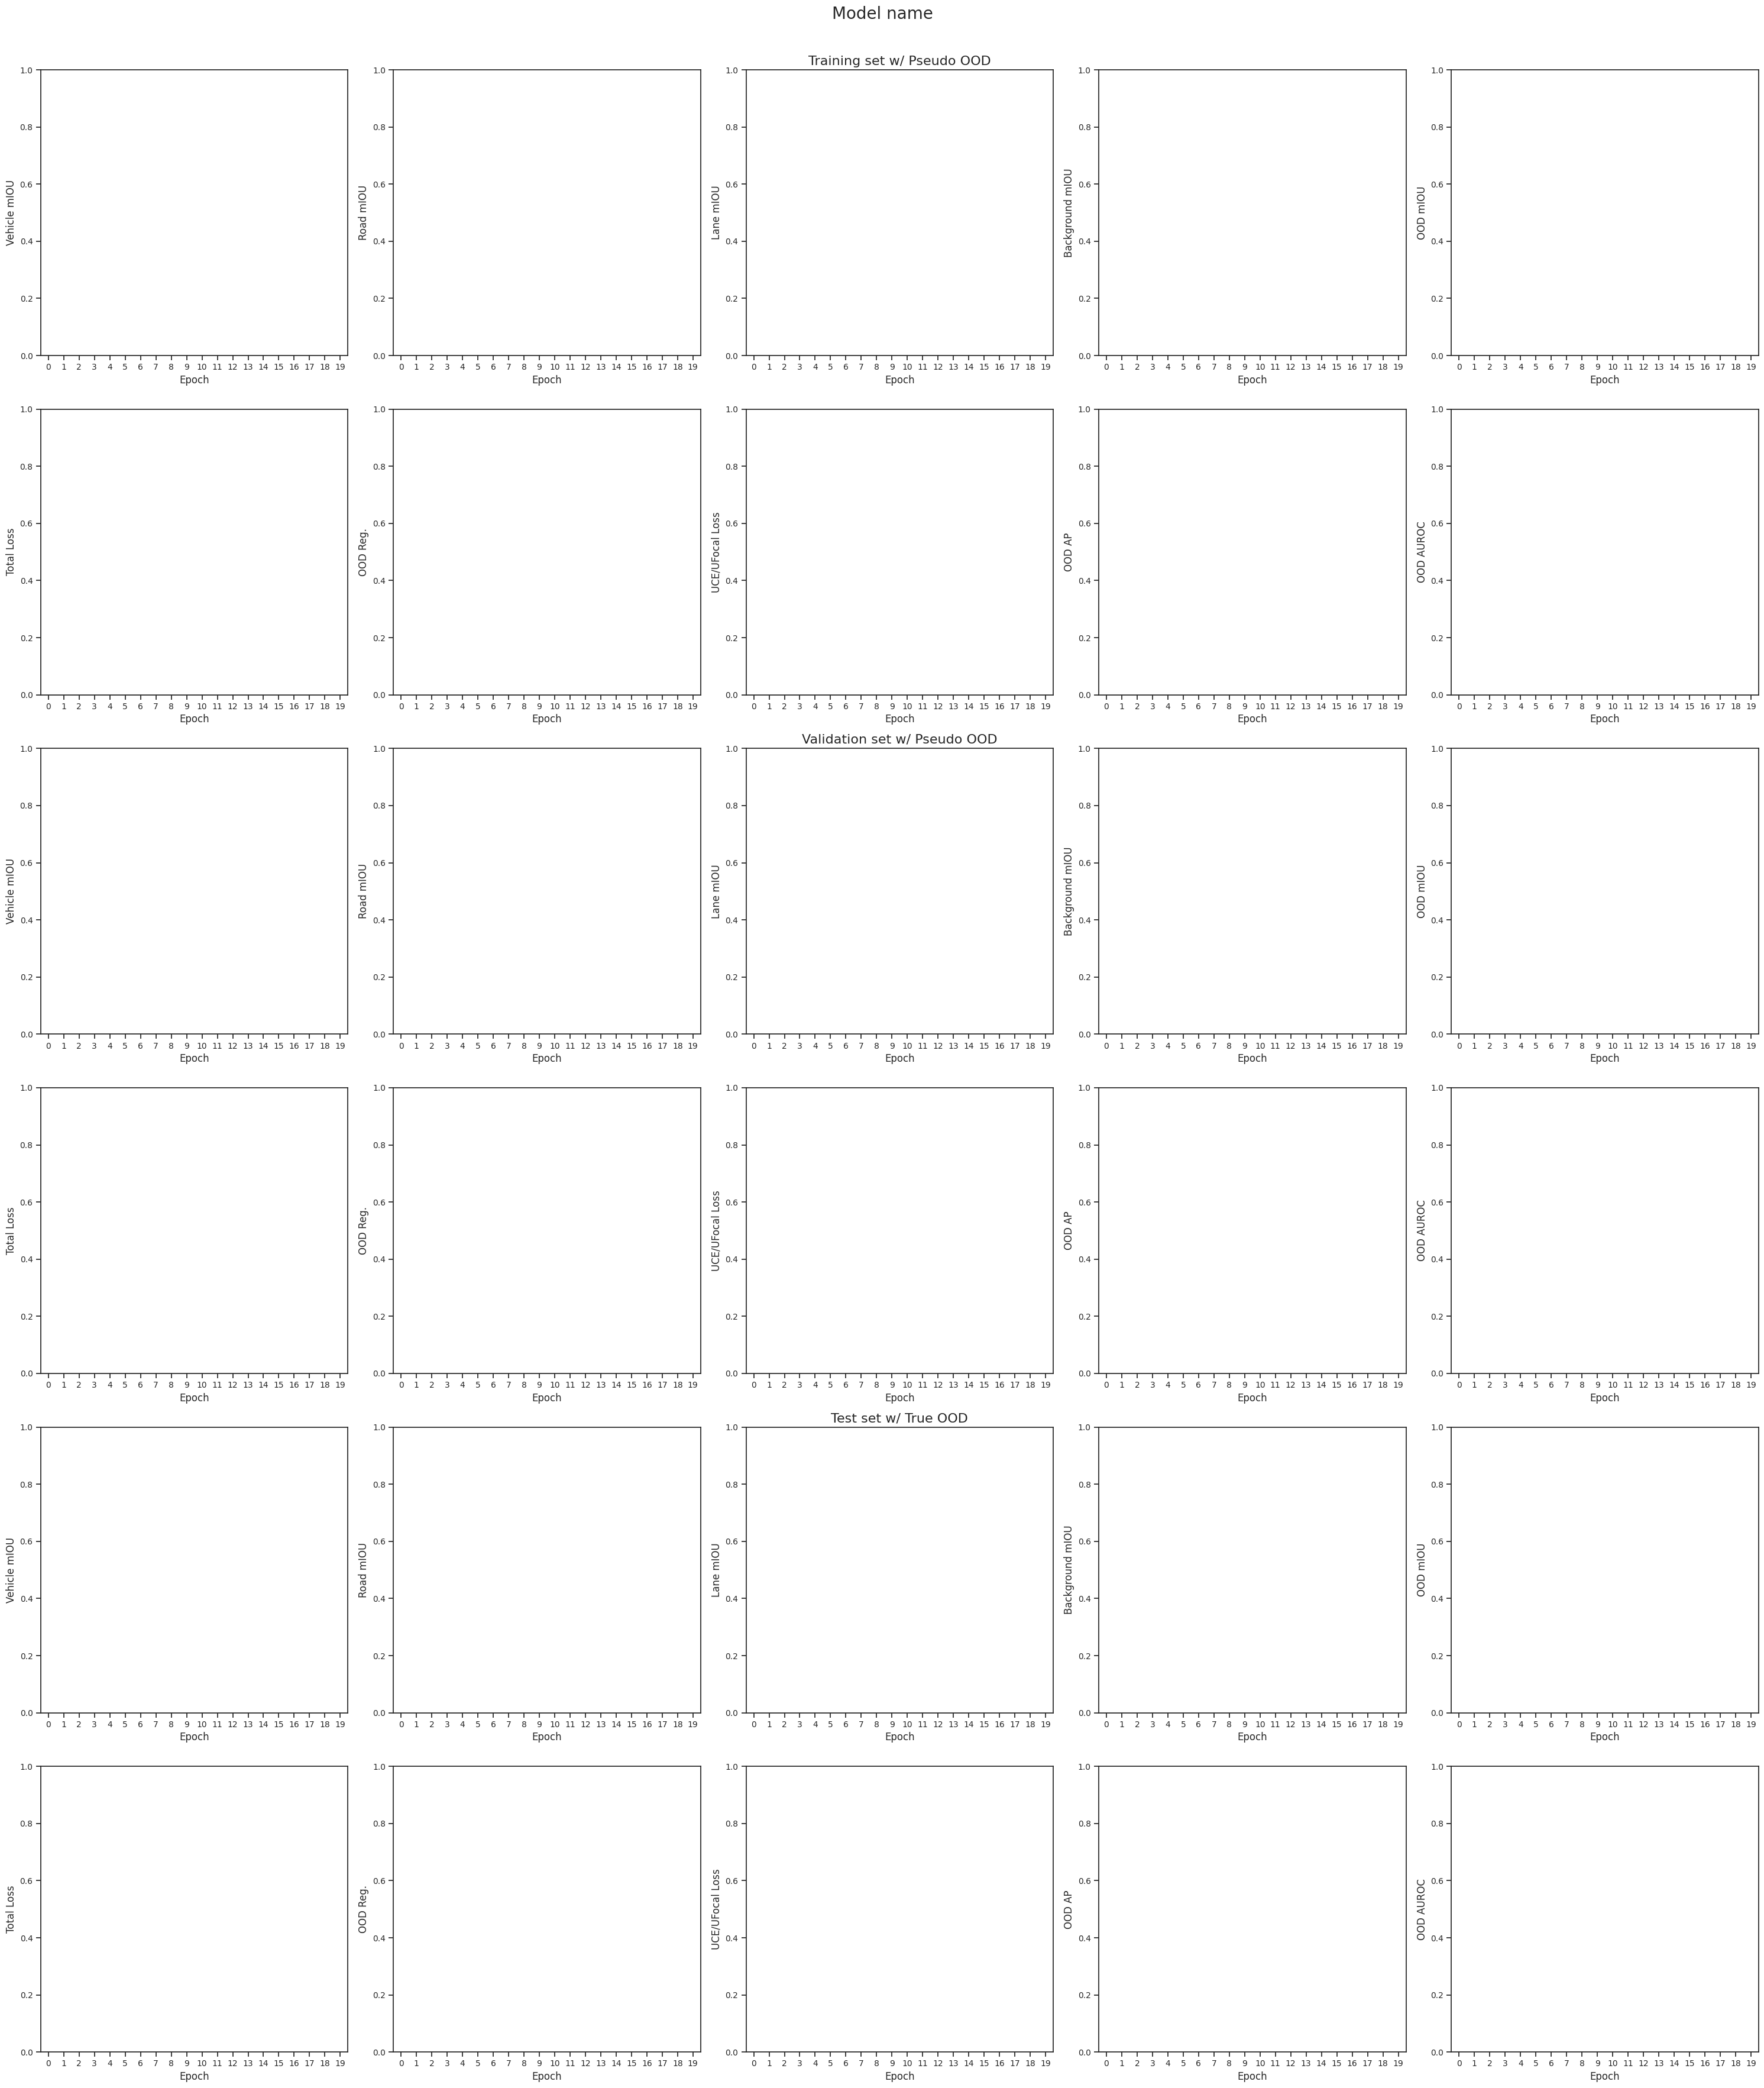

In [155]:
fig, axs = plt.subplots(6, 5, figsize=(30, 36))

fig.suptitle("Model name", fontsize=20)

tags = ["Vehicle mIOU", "Road mIOU", "Lane mIOU", "Background mIOU", "OOD mIOU", 
       "Total Loss", "OOD Reg.", "UCE/UFocal Loss", "OOD AP", "OOD AUROC"]

sets = {
    "train": "Training set w/ Pseudo OOD",
    "val": "Validation set w/ Pseudo OOD",
    "ood": "Test set w/ True OOD",
}

epochs = np.linspace(0, 19, 20)

for si, s in enumerate(sets):
    axs[si*2, 2].set_title(sets[s], fontsize=16)

    for i in range(len(tags)):
        ax = axs[si*2 + i//5, i%5]
        ax.set_xlabel("Epoch", fontsize=12)
        ax.set_ylabel(tag[i], fontsize=12)
        ax.set_xticks(epochs)
        ax.set_xlim(-.5, 19.5)

        ax.tick_params(axis='both', which='both', bottom=True, left=True, labelsize=10)
        
fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18))


fig.subplots_adjust(top=0.95)